# Example usage on a single dataset

## Credit

Here we assume a single data file, create a simple train test split (please aboid when doing proper data sceince - this is only for demonstartion purposes)

Because of mismatches between my personal setup - tensforflow2 on an Apple M1 chip, tensorflow2 is not a prerequisit of the library. But, please install tensorflow2 for you. I used TF2.9

The 'tf.layers.dense' is deprecated and will need more work. For now, only ignore the warnings, or better print them out once.

In [1]:
# issues with : UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.

import warnings
warnings.simplefilter(action='ignore', category=UserWarning) 

For people with a wider screen - use 80% of the display area in Jupyter

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container {width:80% !important;</style>"))


Some tools for dealing with files

In [3]:
import os,os.path

Import hivae and the usual data science libraries

In [4]:
import hivae
import pandas as pd
pd.options.display.float_format = '{:20,.3f}'.format


import numpy as np
import sklearn
import sklearn.compose
import sklearn.model_selection
import scipy.stats

import random 


In [5]:
import matplotlib.pyplot as plt  
%matplotlib inline
import seaborn as sns

In [6]:
# where to find the data and where to save the results - can easily be adopted - variable names should be clear


main_directory = '.'
dataset_name = 'Credit'


# set up paths
# where the data should be found
dataset_path = '{}/data/{}'.format(main_directory,dataset_name)
# where the results will be saved
results_path = '{}/results/{}'.format(main_directory,dataset_name)
# where the networks will be saved
network_path = '{}/network/{}'.format(main_directory,dataset_name)




The credit example comes from the UCI repository:

https://archive.ics.uci.edu/ml/datasets/Credit+Approval

The attribute information is as follows:

```
A1: b, a. 
A2: continuous. 
A3: continuous. 
A4: u, y, l, t. 
A5: g, p, gg. 
A6: c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff. 
A7: v, h, bb, j, n, z, dd, ff, o. 
A8: continuous. 
A9: t, f. 
A10: t, f. 
A11: continuous. 
A12: t, f. 
A13: g, p, s. 
A14: continuous. 
A15: continuous. 
A16: +,- (class attribute)
```


In [7]:
# in this case, the data in in csv, with header accounting for the feature/variable/predictor names. Last column is the class

data_file = '{}/data_org.csv'.format(dataset_path)
data_df   = pd.read_csv(data_file,header=0)



In [8]:
# used to exclude certain features (e.g. class attribute)

feature_class    = 'A16'


# define the categories
features_cat     = ['A1','A4','A5','A6','A7','A9','A10','A12','A13','A16']
features_real    = ['A3','A8','A15']
features_pos     = ['A2','A14']
features_count   = ['A11']


features_ignore  = [feature_class] # add as needed



# filter out attributes which should not be used
features_cat   = [x for x in features_cat if x not in features_ignore]
features_real  = [x for x in features_real if x not in features_ignore]
features_pos   = [x for x in features_pos if x not in features_ignore]
features_count = [x for x in features_count if x not in features_ignore]

features_numerical = features_real+features_pos+features_count

features_use   = [x for x in data_df.columns if x not in features_ignore]


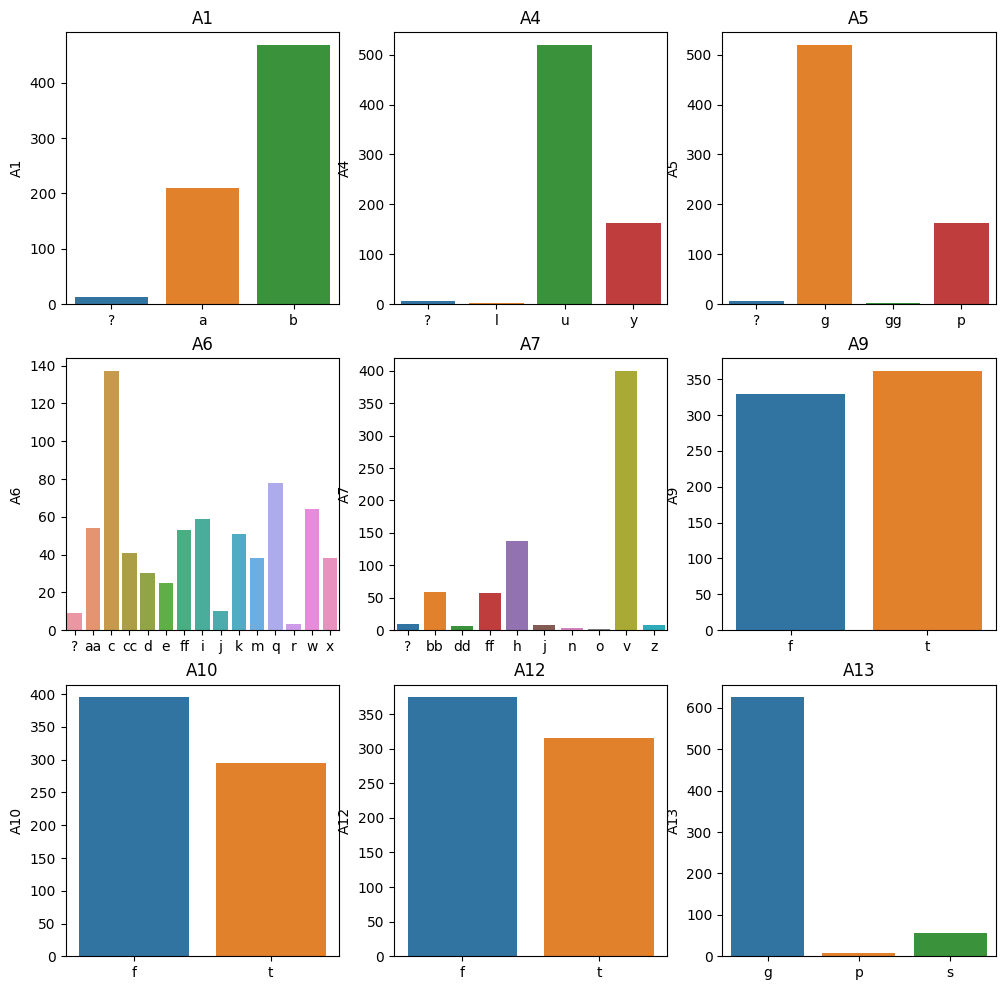

In [9]:
# plot all categoical attribute histograms

plot_cols = 3
plot_rows = int(round((len(features_cat)/plot_cols)))

fig, axes = plt.subplots(nrows=plot_rows, ncols=plot_cols,figsize=(4*plot_cols,4*plot_rows))

axes = axes.flatten()

for ax,attrb in zip(axes,features_cat):
    count_data = data_df[attrb].value_counts().sort_index()
    sns.barplot(x = count_data.index, y = count_data,ax=ax)
    ax.set_title(attrb) 

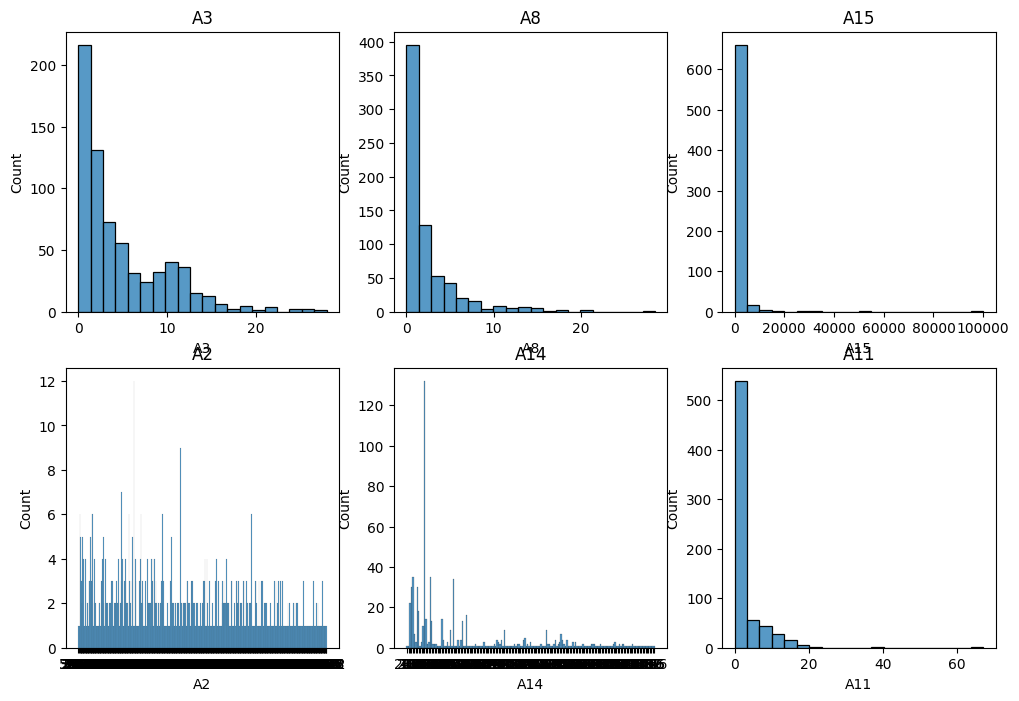

In [10]:
# plot all numerical attribute histograms

plot_cols = 3
plot_rows = int(round((len(features_numerical)/plot_cols)))


fig, axes = plt.subplots(nrows=plot_rows, ncols=plot_cols,figsize=(4*plot_cols,4*plot_rows))
axes = axes.flatten()

for ax,attrb in zip(axes,features_numerical):
    count_data = data_df[attrb]
    sns.histplot(data=count_data,bins=20,ax=ax)
    ax.set_title(attrb) 

For testing and training purposes, we map the original missing data in all attributes to None


In [11]:
#convert numrical data:
for attrib in features_numerical:
    mask = data_df[attrib]=='?'
    data_df.loc[mask, attrib] = np.nan
    data_df[attrib] = data_df[attrib].astype(float)

# deal with missing in categorical data
for attrib in features_cat:
    mask = data_df[attrib]=='?'
    data_df.loc[mask, attrib] = np.nan
    



In [12]:
# here a simple train- test split

data_df[feature_class] = data_df[feature_class].map({'+':1,'-':0,1:1,0:0}) # identy mapping for repeated jupyter use

shuffle_split = sklearn.model_selection.StratifiedShuffleSplit(test_size=0.4,random_state=42)
loc_train,loc_test = list(shuffle_split.split(X=data_df[features_use],y=data_df[feature_class]))[0]

data_df_train = data_df.iloc[loc_train]
data_df_test  = data_df.iloc[loc_test]


In [13]:
# generate additional missing data

miss_percentage = 0.1

data_df_train_miss = data_df_train.copy()
data_df_test_miss = data_df_test.copy()

for attrib in features_use:
    
    attribs_not_none_train = list(data_df_train_miss[attrib].dropna().index)
    random.shuffle(attribs_not_none_train)
    missing_test_nums = attribs_not_none_train[:int(len(attribs_not_none_train)*miss_percentage)]
    #print(attrib,len(attribs_not_none_train),len(missing_test_nums))
    data_df_train_miss.loc[missing_test_nums,attrib] = np.nan
    
    attribs_not_none_test = list(data_df_test_miss[attrib].dropna().index)
    random.shuffle(attribs_not_none_test)
    missing_test_nums = attribs_not_none_test[:int(len(attribs_not_none_test)*miss_percentage)]
    data_df_test_miss.loc[missing_test_nums,attrib] = np.nan
    




In [14]:
# define transformers to get data ready


#StandardScaler() # asumption would be Gaussian - not true here
transformer_pos   = sklearn.preprocessing.FunctionTransformer(feature_names_out='one-to-one') # itendentity function, keep more or less original names

# real 
transformer_real   = sklearn.preprocessing.PowerTransformer()  # itendentity function, keep more or less original names

# count data - again no changes here
transformer_count = sklearn.preprocessing.FunctionTransformer(feature_names_out='one-to-one') # itendentity function, keep more or less original names

transformer_cat   = sklearn.preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=np.nan,encoded_missing_value=np.nan) # simply numbers for each value



# put together all transformers in preprocessor pipeline
preprocessor = sklearn.compose.ColumnTransformer(
    transformers=[
        ('pos', transformer_pos, features_pos),
        ('real', transformer_real, features_real),
        ('count', transformer_count, features_count),
        ('cat', transformer_cat, features_cat),

    ])

preprocessor.fit(data_df_train[features_use])

# the preprocesser reorders the input according to the order of the preprocessor
# see https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
columns_inorder = [x.split('__')[1] for x in preprocessor.get_feature_names_out()]

# transforms the data according to the preprocessor and keeps the original columns names
data_df_train_pre      = pd.DataFrame(preprocessor.transform(data_df_train[features_use]),columns=columns_inorder,index=data_df_train.index)[features_use]
data_df_test_pre       = pd.DataFrame(preprocessor.transform(data_df_test[features_use]),columns=columns_inorder,index=data_df_test.index)[features_use]
data_df_train_miss_pre = pd.DataFrame(preprocessor.transform(data_df_train_miss[features_use]),columns=columns_inorder,index=data_df_train_miss.index)[features_use]
data_df_test_miss_pre  = pd.DataFrame(preprocessor.transform(data_df_test_miss[features_use]),columns=columns_inorder,index=data_df_test_miss.index)[features_use]




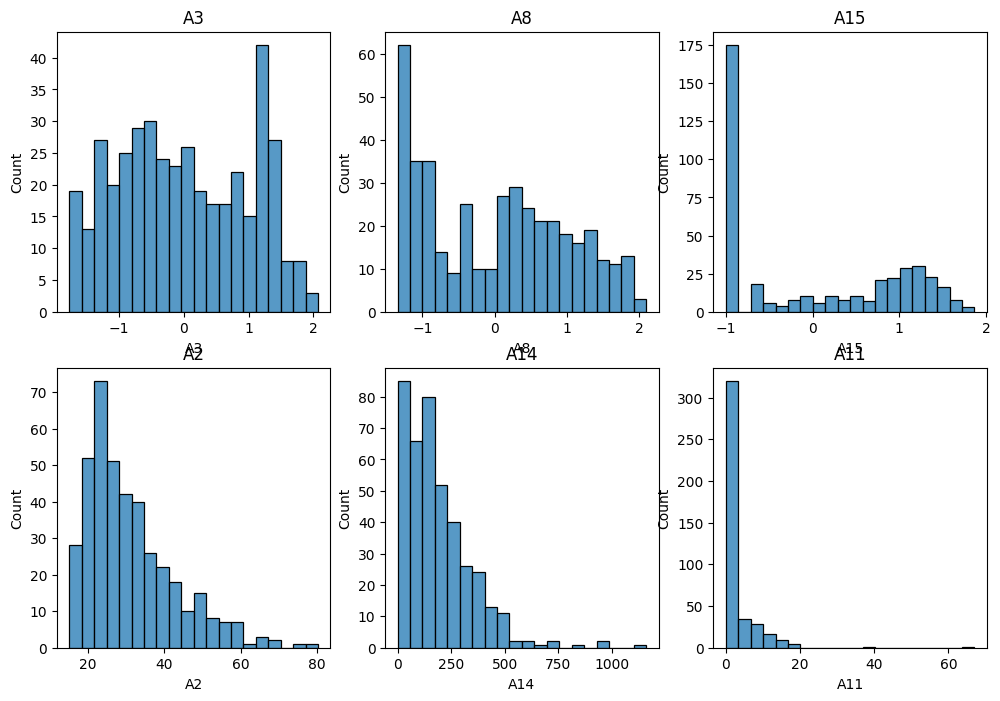

In [15]:
# plot all numerical attribute histograms

plot_cols = 3
plot_rows = int(round((len(features_numerical)/plot_cols)))


fig, axes = plt.subplots(nrows=plot_rows, ncols=plot_cols,figsize=(4*plot_cols,4*plot_rows))
axes = axes.flatten()

for ax,attrb in zip(axes,features_numerical):
    count_data = data_df_train_pre[attrb]
    sns.histplot(data=count_data,bins=20,ax=ax)
    ax.set_title(attrb) 

In [16]:
def generate_missing_mask(df,features_use):
    df_missing_mask  = pd.DataFrame(columns=features_use,index=df.index)
    for x in features_use:
        df_missing_mask[x] = df[x].isna().map({True:0,False:1})
    return df_missing_mask

data_df_train_pre_missing_mask      = generate_missing_mask(data_df_train_pre,features_use)
data_df_test_pre_missing_mask       = generate_missing_mask(data_df_test_pre,features_use)
data_df_train_miss_pre_missing_mask = generate_missing_mask(data_df_train_miss_pre,features_use)
data_df_test_miss_pre_missing_mask  = generate_missing_mask(data_df_test_miss_pre,features_use)







In [17]:
data_df_train_pre

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
50,0.000,25.750,-1.192,1.000,0.000,1.000,3.000,-0.064,1.000,0.000,0.000,1.000,0.000,491.000,-1.001
483,1.000,23.750,-1.272,2.000,2.000,1.000,7.000,-1.249,0.000,1.000,2.000,0.000,0.000,128.000,-0.129
228,1.000,19.670,-1.312,1.000,0.000,10.000,7.000,0.611,1.000,1.000,2.000,1.000,0.000,80.000,-1.001
244,1.000,18.500,-0.289,1.000,0.000,6.000,7.000,0.373,1.000,1.000,2.000,0.000,0.000,120.000,0.991
223,0.000,18.830,1.120,1.000,0.000,0.000,7.000,-1.149,1.000,0.000,0.000,0.000,0.000,100.000,-1.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,1.000,26.750,-0.289,1.000,0.000,3.000,7.000,-0.181,0.000,0.000,0.000,1.000,0.000,80.000,-1.001
54,1.000,34.250,0.058,1.000,0.000,2.000,3.000,1.545,1.000,0.000,0.000,1.000,0.000,0.000,-1.001
8,1.000,54.420,-1.192,2.000,2.000,8.000,3.000,1.142,1.000,0.000,0.000,0.000,0.000,180.000,1.001
449,1.000,20.000,0.834,1.000,0.000,1.000,7.000,-0.462,0.000,0.000,0.000,0.000,0.000,0.000,-1.001


In [18]:
# in case you want to chack

#display(data_df[data_df['A1'].isna()][features_use])
#display(data_df_pre[data_df['A1'].isna()][features_use])
#display(data_df_pre_missing[data_df['A1'].isna()][features_use])

In [19]:
# define type list

types_list = []

for attrib in features_use:
    # categotical
    if attrib in features_cat:
        num_cats = len(data_df_train_pre[attrib].dropna().unique()) # ther might be a problem as training data does not contain all categories
        types_list += [(attrib,'cat',num_cats,num_cats)]
    elif attrib in features_pos:
        types_list += [(attrib,'pos',1,None)]
    elif attrib in features_real:
        types_list += [(attrib,'real',1,None)]
    elif attrib in features_count:
        types_list += [(attrib,'count',1,None)]



In [20]:
# define parameters for hivae
network_def = {
        'batch_size' : 32,
        'model_name': 'model_HIVAE_inputDropout',
        'dim_z': 10, # embedding (bottleneck)
        'dim_y': 5,
        'dim_s': 10,
    }

epochs = 100 # might be much too high


In [21]:
# create hivae object, setting file paths
hivae_obj = hivae.hivae(types_list,network_def,results_path=results_path,network_path=network_path)



In [22]:
hivae_obj.fit(data_df_train_pre,epochs=epochs,true_missing_mask=data_df_train_pre_missing_mask)



Metal device set to: Apple M1


2022-08-26 13:10:41.899290: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-26 13:10:41.899388: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-08-26 13:10:41.956629: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-08-26 13:10:41.984104: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-26 13:10:41.985477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-26 13:10:42.142666: I tensorflow/core/grappler/optimizers/custom_graph

INFO:tensorflow:./network/Credit/model_HIVAE_inputDropout_s10_z10_y5_batch32_5c339293-02b1-43e2-806b-1fc032925dd3_ckpt.data-00000-of-00001
INFO:tensorflow:0
INFO:tensorflow:./network/Credit/model_HIVAE_inputDropout_s10_z10_y5_batch32_5c339293-02b1-43e2-806b-1fc032925dd3_ckpt.index
INFO:tensorflow:0
INFO:tensorflow:./network/Credit/model_HIVAE_inputDropout_s10_z10_y5_batch32_5c339293-02b1-43e2-806b-1fc032925dd3_ckpt.meta
INFO:tensorflow:1300


In [23]:
# use train with additional missing data to fill = just for checking
(train_rec_data, train_rec_data_reconstructed, train_rec_data_decoded, _, _) = hivae_obj.predict(data_df_train_miss_pre,true_missing_mask=data_df_train_miss_pre_missing_mask)

df_train_rec_data               = pd.DataFrame(train_rec_data,columns=features_use,index=data_df_train.index)
df_train_rec_data_reconstructed = pd.DataFrame(train_rec_data_reconstructed,columns=features_use,index=data_df_train.index)
df_train_rec_data_decoded       = pd.DataFrame(train_rec_data_decoded,columns=features_use,index=data_df_train.index)


# reverse transform to display in original domain
df_train_rec_data_reconstructed_re = pd.DataFrame(columns=features_use,index=data_df_train.index)

for (trans_type,trans_fitted,trans_attribs) in preprocessor.transformers:
    trans_fitted = preprocessor.named_transformers_[trans_type] # get the fitted transformer - somehow the trans_fitted from transformers is not fitted.
    df_train_rec_data_reconstructed_re[trans_attribs] = pd.DataFrame(trans_fitted.inverse_transform(df_train_rec_data_reconstructed[trans_attribs]),
                                                                                columns=trans_attribs,index=data_df_train.index)
    # there seems to be an mistake in the count data (seems to be +1 everywhere)
    if trans_type=='count':
        df_train_rec_data_reconstructed_re[trans_attribs] -= 1

# display original        
display(data_df_train[features_use].head(20))

# display train with additional missing data
display(data_df_train_miss[features_use].head(20))

# display with missing data filled
display(df_train_rec_data_reconstructed_re.head(20))


INFO:tensorflow:Restoring parameters from ./network/Credit/model_HIVAE_inputDropout_s10_z10_y5_batch32_5c339293-02b1-43e2-806b-1fc032925dd3_ckpt


2022-08-26 13:15:02.918718: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-26 13:15:02.918741: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-08-26 13:15:03.019660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-26 13:15:03.076674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-26 13:15:03.709947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-26 13:15:03.94

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
50,a,25.750,0.500,u,g,c,h,0.875,t,f,0.000,t,g,491.000,0.000
483,b,23.750,0.415,y,p,c,v,0.040,f,t,2.000,f,g,128.000,6.000
228,b,19.670,0.375,u,g,q,v,2.000,t,t,2.000,t,g,80.000,0.000
244,b,18.500,2.000,u,g,i,v,1.500,t,t,2.000,f,g,120.000,300.000
223,a,18.830,9.540,u,g,aa,v,0.085,t,f,0.000,f,g,100.000,0.000
437,a,53.330,0.165,u,g,ff,ff,0.000,f,f,0.000,t,s,62.000,27.000
576,b,30.170,0.500,u,g,c,v,1.750,t,t,11.000,f,g,32.000,540.000
499,b,20.420,7.000,u,g,c,v,1.625,t,t,3.000,f,g,200.000,"1,391.000"
336,b,47.330,6.500,u,g,c,v,1.000,f,f,0.000,t,g,0.000,228.000
197,b,48.170,7.625,u,g,w,h,15.500,t,t,12.000,f,g,0.000,790.000


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
50,a,25.750,NaN,NaN,g,c,h,0.875,t,f,0.000,t,g,491.000,0.000
483,b,23.750,NaN,y,NaN,c,v,0.040,f,t,2.000,f,g,128.000,6.000
228,b,19.670,0.375,u,g,q,NaN,2.000,t,t,2.000,t,g,80.000,0.000
244,b,18.500,2.000,u,g,i,v,NaN,t,t,2.000,f,NaN,120.000,300.000
223,a,18.830,9.540,u,NaN,NaN,v,0.085,t,f,0.000,f,g,100.000,0.000
437,a,53.330,0.165,u,g,ff,ff,0.000,f,f,0.000,t,s,62.000,27.000
576,b,30.170,0.500,u,g,c,NaN,1.750,t,t,11.000,NaN,g,32.000,540.000
499,b,20.420,7.000,u,g,c,v,1.625,t,t,NaN,f,g,200.000,"1,391.000"
336,b,47.330,NaN,u,g,c,v,1.000,f,f,0.000,t,g,0.000,228.000
197,b,48.170,7.625,u,g,w,NaN,15.500,t,t,12.000,f,g,0.000,790.000


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
50,a,25.750,2.119,u,g,c,h,0.875,t,f,0.000,t,g,491.000,-0.000
483,b,23.750,1.822,y,p,c,v,0.040,f,t,2.000,f,g,128.000,6.000
228,b,19.670,0.375,u,g,q,v,2.000,t,t,2.000,t,g,80.000,-0.000
244,b,18.500,2.000,u,g,i,v,1.189,t,t,2.000,f,g,120.000,300.000
223,a,18.830,9.540,u,g,c,v,0.085,t,f,0.000,f,g,100.000,-0.000
437,a,53.330,0.165,u,g,ff,ff,0.000,f,f,0.000,t,s,62.000,27.000
576,b,30.170,0.500,u,g,c,v,1.750,t,t,11.000,t,g,32.000,540.000
499,b,20.420,7.000,u,g,c,v,1.625,t,t,1.000,f,g,200.000,"1,391.000"
336,b,47.330,3.120,u,g,c,v,1.000,f,f,0.000,t,g,0.000,228.000
197,b,48.170,7.625,u,g,w,v,15.500,t,t,12.000,f,g,0.000,790.000


In [24]:

df_train_rec_data_reconstructed_re = pd.DataFrame(columns=features_use,index=data_df_train.index)

for (trans_type,trans_fitted,trans_attribs) in preprocessor.transformers:
    trans_fitted = preprocessor.named_transformers_[trans_type] # get the fitted transformer - somehow the trans_fitted from transformers is not fitted.
    df_train_rec_data_reconstructed_re[trans_attribs] = pd.DataFrame(trans_fitted.inverse_transform(df_train_rec_data_reconstructed[trans_attribs]),
                                                                                columns=trans_attribs,index=data_df_train.index)
    if trans_type=='count':
        df_train_rec_data_reconstructed_re[trans_attribs] -= 1



In [25]:
# now the same on the real test 

(test_rec_data, test_rec_data_reconstructed, test_rec_data_decoded, _, _) = hivae_obj.predict(data_df_test_miss_pre,true_missing_mask=data_df_test_miss_pre_missing_mask)

df_test_rec_data               = pd.DataFrame(test_rec_data,columns=features_use,index=data_df_test.index)
df_test_rec_data_reconstructed = pd.DataFrame(test_rec_data_reconstructed,columns=features_use,index=data_df_test.index)
df_test_rec_data_decoded       = pd.DataFrame(test_rec_data_decoded,columns=features_use,index=data_df_test.index)


df_test_rec_data_reconstructed_re = pd.DataFrame(columns=features_use,index=data_df_test.index)

for (trans_type,trans_fitted,trans_attribs) in preprocessor.transformers:
    trans_fitted = preprocessor.named_transformers_[trans_type] # get the fitted transformer - somehow the trans_fitted from transformers is not fitted.
    df_test_rec_data_reconstructed_re[trans_attribs] = pd.DataFrame(trans_fitted.inverse_transform(df_test_rec_data_reconstructed[trans_attribs]),
                                                                                columns=trans_attribs,index=data_df_test.index)
    if trans_type=='count':
        df_test_rec_data_reconstructed_re[trans_attribs] -= 1

display(data_df_test[features_use].head(20))

display(data_df_test_miss[features_use].head(20))

display(df_test_rec_data_reconstructed_re.head(20))




INFO:tensorflow:Restoring parameters from ./network/Credit/model_HIVAE_inputDropout_s10_z10_y5_batch32_5c339293-02b1-43e2-806b-1fc032925dd3_ckpt


2022-08-26 13:15:07.002414: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-26 13:15:07.002434: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-08-26 13:15:07.090581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-26 13:15:07.151609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-26 13:15:07.823477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-26 13:15:08.00

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
280,b,21.170,0.875,y,p,c,h,0.250,f,f,0.000,f,g,280.000,204.000
198,b,27.580,2.040,y,p,aa,v,2.000,t,t,3.000,t,g,370.000,560.000
15,b,36.670,4.415,y,p,k,v,0.250,t,t,10.000,t,g,320.000,0.000
403,a,22.670,0.335,u,g,q,v,0.750,f,f,0.000,f,s,160.000,0.000
172,b,56.000,12.500,u,g,k,h,8.000,t,f,0.000,t,g,24.000,"2,028.000"
608,b,NaN,0.040,y,p,d,v,4.250,f,f,0.000,t,g,460.000,0.000
0,b,30.830,0.000,u,g,w,v,1.250,t,t,1.000,f,g,202.000,0.000
140,a,31.250,3.750,u,g,cc,h,0.625,t,t,9.000,t,g,181.000,0.000
554,a,22.420,11.250,y,p,x,h,0.750,t,t,4.000,f,g,0.000,321.000
468,b,22.080,2.335,u,g,k,v,0.750,f,f,0.000,f,g,180.000,0.000


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
280,b,21.170,0.875,y,p,c,h,0.250,f,f,0.000,f,g,280.000,204.000
198,b,27.580,2.040,y,p,aa,v,2.000,t,t,3.000,t,g,370.000,560.000
15,b,36.670,4.415,y,p,NaN,v,0.250,t,t,10.000,t,g,NaN,0.000
403,NaN,22.670,0.335,u,g,q,NaN,0.750,f,f,0.000,f,s,NaN,0.000
172,b,NaN,12.500,u,g,k,h,8.000,t,f,0.000,t,NaN,24.000,"2,028.000"
608,b,NaN,0.040,y,p,NaN,v,4.250,f,NaN,0.000,NaN,g,460.000,0.000
0,b,30.830,0.000,u,g,w,v,1.250,t,t,1.000,f,g,202.000,0.000
140,a,NaN,3.750,u,g,cc,h,0.625,t,t,9.000,t,NaN,181.000,0.000
554,a,22.420,11.250,y,NaN,x,h,0.750,t,t,4.000,NaN,NaN,0.000,321.000
468,b,22.080,2.335,u,g,k,NaN,0.750,f,f,0.000,f,g,180.000,0.000


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
280,b,21.170,0.875,u,gg,c,h,0.250,f,f,0.000,f,g,280.000,204.000
198,b,27.580,2.040,u,gg,aa,o,2.000,t,t,3.000,t,g,370.000,560.000
15,b,36.670,4.415,u,gg,m,o,0.250,t,t,10.000,t,g,39.004,-0.000
403,b,22.670,0.335,l,g,q,v,0.750,f,f,0.000,f,s,20.897,-0.000
172,b,37.477,12.500,l,g,k,h,8.000,t,f,0.000,t,g,24.000,"2,028.000"
608,b,27.528,0.040,u,gg,i,o,4.250,f,f,0.000,t,g,460.000,-0.000
0,b,30.830,0.000,l,g,r,o,1.250,t,t,1.000,f,g,202.000,-0.000
140,a,28.617,3.750,l,g,cc,h,0.625,t,t,9.000,t,g,181.000,-0.000
554,a,22.420,11.250,u,g,w,h,0.750,t,t,4.000,f,g,0.000,321.000
468,b,22.080,2.335,l,g,k,v,0.750,f,f,0.000,f,g,180.000,-0.000
